<a href="https://colab.research.google.com/github/mariacm12/AE_qbath/blob/main/AE_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#<center>Encoding the effect of a quantum bath using unsupervised learning<center>

---
<center> Maria A. Castellanos <center>




#Import functions & download data

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')
mydrive = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#various
import os
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import scipy

#pytorch
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

#plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm, Normalize

#Differential equation package for pytorch
!pip install torchdiffeq
from torchdiffeq import odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Get data 

! wget 5000_configs_300K.zip https://www.dropbox.com/s/seqzh0o14wzec9z/5000_configs_300K.zip?dl=0
! wget 3000_configs_300K.zip https://www.dropbox.com/s/pwjpzkyqsgzgd6e/3000_configs_300K.zip?dl=0

!unzip 5000_configs_300K.zip?dl=0 -d ./300K
!unzip 3000_configs_300K.zip?dl=0 -d ./300K_more

Streaming output truncated to the last 5000 lines.
  inflating: ./300K_more/MORE_TRAJECTORIES/config_1579/pldm.1-1  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_1579/initial_nuclear_xp.dat  
   creating: ./300K_more/MORE_TRAJECTORIES/config_424/
  inflating: ./300K_more/MORE_TRAJECTORIES/config_424/pldm.1-2  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_424/pldm.2-1  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_424/pldm.2-2  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_424/pldm.1-1  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_424/initial_nuclear_xp.dat  
   creating: ./300K_more/MORE_TRAJECTORIES/config_818/
  inflating: ./300K_more/MORE_TRAJECTORIES/config_818/pldm.1-2  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_818/pldm.2-1  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_818/pldm.2-2  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_818/pldm.1-1  
  inflating: ./300K_more/MORE_TRAJECTORIES/config_818/initial_nuclear_xp.dat  
   creating: ./

In [ ]:
#data from closed system
## Note that this file is stored in my personal drive. I can provide it upon request, if needed. 
closed_pop = np.loadtxt('{}/Final_proj/close_data.txt'.format(mydrive))

# Pre-processing the data

In [ ]:
nconfigs3 = 1000
nconfigs300 = [5000,3000]
npoints = 2000

#300K
rho1=np.array([np.loadtxt("./300K/config_"+str(conf)+"/pldm.1-1")[:,1] for conf in range(1,nconfigs300[0]+1)])
rho2=np.array([np.loadtxt("./300K_more/MORE_TRAJECTORIES/config_"+str(conf)+"/pldm.1-1")[:,1] for conf in range(1,nconfigs300[1]+1)])
rho300_00 = np.concatenate((rho1,rho2)) # the rho_00 matrix element of the density matrix, or the electronic population of state |0>

In [ ]:
#Fourier Transform of time domain data
def fourier_data(time_data):
    tot_points = npoints+1
    ft = np.fft.fft(time_data,axis=-1)[1:]
    freq = np.fft.fftfreq(tot_points)
    return ft,freq
ft300, freq300 = fourier_data(rho300_00)

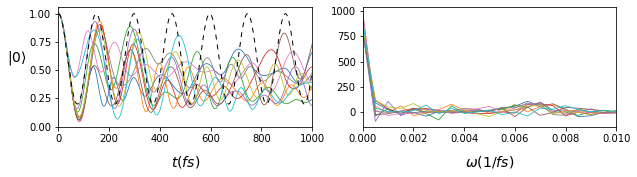

In [ ]:
#Plotting a few samples in time and frequency domain

# Make Figure & Axes
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,2.2))

ax1.set_xlabel(r'$t(fs)$', rotation=0, size=14, labelpad=10)
ax1.set_ylabel(r'$|0\rangle$', rotation=0, size=14, labelpad=12)
ax2.set_xlim(0,0.01)
for b in range(0,10):
    ax1.plot(rho300_00[b], linewidth=0.8)#, color=cmap(norm(b)))
    ax2.plot(freq300[:1000],np.real(ft300[b])[:1000], linewidth=0.8)

ax2.set_xlabel(r'$\omega(1/fs)$', rotation=0, size=14, labelpad=10)

ax1.set_xlim(0,1000)
ax1.plot(closed_pop,color='black',linestyle=(0, (5, 5)),linewidth=1)

plt.savefig("%s.eps" % (mydrive+'/Final_proj/dataset_singles'),bbox_inches='tight')


In [ ]:
#Function to create ensembles of size k
k=4
etotal = 5000
def choose_ens(sample,k,etotal):
  ensem = []
  for en in range(etotal):
    nsamples = sample.shape[0]
    idx = np.random.randint(nsamples, size=k)
    e_choice = sample[idx]
    avg_ens = np.mean(e_choice,axis=0)
    ensem.append(avg_ens)

  return np.array(ensem)

ens_300 = choose_ens(rho300_00,k,etotal)

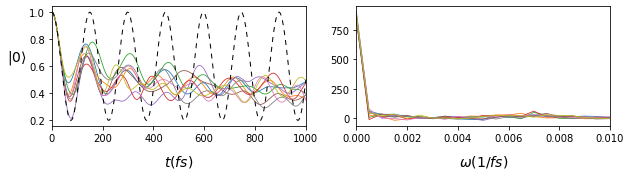

In [ ]:
#Plotting a few samples of ensembles of size 4. For time and freq domain

en_fft, en_freq = fourier_data(ens_300)
en_fft_re = np.real(en_fft)
en_fft_im = np.imag(en_fft)

#The full Re+Im matrix
en_fft_ap = np.concatenate((en_fft_re,en_fft_im),axis=1)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,2.2))

ax1.set_xlabel(r'$t(fs)$', rotation=0, size=14, labelpad=10)
ax1.set_ylabel(r'$|0\rangle$', rotation=0, size=14, labelpad=12)
for b in range(1,10):
    ax1.plot(ens_300[b], linewidth=0.8)
    ax2.plot(en_freq[:1000],np.real(en_fft[b])[:1000], linewidth=0.8)
ax2.set_xlabel(r'$\omega(1/fs)$', rotation=0, size=14, labelpad=10)
ax2.set_xlim(0,0.01)
ax1.set_xlim(0,1000)
ax1.plot(closed_pop,color='black',linestyle=(0, (5, 5)),linewidth=1)

plt.savefig("%s.eps" % (mydrive+'/Final_proj/dataset_ensembs'),bbox_inches='tight')

A function to reconstruc the time-series from its power spectrum matrix

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

Text(0.5, 0, 'fs')

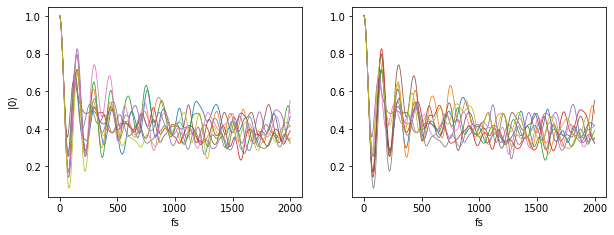

In [ ]:
def power_recon(all_ps):
    re_ft = all_ps[:,:npoints+1]
    im_ft = all_ps[:,npoints+1:]
    ps = re_ft + im_ft*1j

    #Inverse fourier transform
    t_recon = np.fft.ifft(ps,axis=-1)

    return t_recon

#Testing if it works

t_recon = power_recon(en_fft_ap)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))

ax1.set_xlabel('fs')
ax1.set_ylabel(r'$|0\rangle$')
for b in range(1,10):
    ax1.plot(ens_300[b], linewidth=0.8)
    ax2.plot(t_recon[b], linewidth=0.8)
ax2.set_xlabel('fs')


Creating dataset and train/val/test splits

In [ ]:
class Data(Dataset):
  def __init__(self,t_series,fourier=False):
      self.data=t_series
  def __getitem__(self,idx):
      sample = self.data[idx]
      return sample
  def __len__(self):
      return len(self.data)

In [ ]:
fourier = True
X = torch.from_numpy(en_fft_ap)

X_train0, X_test = train_test_split(X, train_size=0.8)
X_train, X_val = train_test_split(X_train0, train_size=0.9)

traindata = Data(X_train,fourier)
valdata = Data(X_val,fourier)
testdata = Data(X_test,fourier)

# Build dataloader 
batchsize = 5
train_loader = DataLoader(dataset=traindata,batch_size=batchsize,shuffle=True)
val_loader = DataLoader(dataset=valdata,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(dataset=testdata,batch_size=batchsize,shuffle=True)

#Hyperparameter optimization

In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score
from sympy.utilities.iterables import multiset_permutations

#pseudo hyperparameter optimization function
def hyperopt(loop, vae, loaders, enc, dec, param, input_dim, z_dim, loss_fn, n_epochs=3, ode=None):
    
    '''Trains the nn for given number of epochs, for each hyperparam combination.
        The combination resulting in the smallest total lost (for the last epoch) is selected.
        Args:
        param: Dictionary containing parameters to optimize 
        loop: Function that trains the model
        n_epochs: Number of epochs each combination is trained in 
    '''
    enc_hids = param['enc_dim'] #assume dimensions for encoding/decoding are the same
    rnn_layers = param['rnn_layers']
    beta_loss = param['beta']
    lr_loss = param['lr']

    all_loss = []
    combs = []
    for i, ehid in enumerate(enc_hids):
        for j, rnn in enumerate(rnn_layers):
            for k, beta in enumerate(beta_loss):
                for l, lr in enumerate(lr_loss):

                    encoder = enc(input_dim=input_dim,hidden_dim=ehid, z_dim=z_dim, rnn_layers=rnn)
                    decoder = dec(z_dim=z_dim, hidden_dim=ehid, output_dim=input_dim, rnn_layers=rnn)
                    model = vae(encoder, decoder, ode)
                    model.to(device)
                    optimizer = optim.Adam(model.parameters(),lr=lr)
                    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 
                                                                    factor=0.5, patience=5, verbose=True)
                    
                    print('hidden dim = {}, rnn_layers = {}, beta = {} and lr = {}'.format(ehid,rnn,beta,lr))

                    #Running for n_epochs
                    for epoch in range(0, n_epochs):    
                        train_loss = loop(model, train_loader, epoch, loss_fn, optimizer, beta)
                        val_loss = loop(model, val_loader, epoch, loss_fn,optimizer, beta, evaluation=True)
                        scheduler.step(val_loss)
                        if epoch == 0:
                            best_loss = train_loss.item()
                        else:
                            if train_loss.item() < best_loss:
                                best_loss = train_loss.item()

                    all_loss.append(val_loss)
                    combs.append([i,j,k,l])
            
    best_idx = np.argmin(np.array(all_loss))
    best_par = combs[best_idx]
          
    best_ehid = param['enc_dim'][int(best_par[0])]
    best_rnn = param['rnn_layers'][int(best_par[1])]
    best_beta = param['beta'][int(best_par[2])]
    best_lr = param['lr'][int(best_par[3])]

    return best_ehid, best_rnn, best_beta, best_lr, all_loss[best_idx]


#Implementing a simple (vanilla) VAE (input in the power spectrum)

VAE implementation

In [ ]:
class Encoder(nn.Module):
        ''' This the encoder part of VAE

              Args:
          input_dim: A integer indicating the size of input.
          hidden_dim: A integer indicating the size of hidden dimension.
          rnn_layers: number of recurrent layers for the GRU decoder
          z_dim: A integer indicating the latent dimension.

        '''
        def __init__(self, input_dim, hidden_dim, z_dim, rnn_layers=0):
            super().__init__()

            self.rnn_layers = rnn_layers
            self.z_dim = z_dim

            #Arquitechture when including the rnn
            if rnn_layers > 0:
                self.rnn = nn.GRU(input_dim, hidden_dim, rnn_layers, batch_first=True)
                self.r2lin = nn.Linear(hidden_dim, z_dim * 2)

            #Simple 1-hiddden unit for vanilla VAE
            self.linear = nn.Linear(input_dim, hidden_dim)#(rnn_enc_dim, hidden_dim)
            self.mu = nn.Linear(hidden_dim, z_dim)
            self.var = nn.Linear(hidden_dim, z_dim)
        

        def forward(self, x):
            if self.rnn_layers > 0:
                output, _ = self.rnn(x.unsqueeze(0).float())
                # take last step trough the dense layer
                hid = output[:, -1, :]
                #Hidden layer for mu and var
                out_enc = self.r2lin(hid)
                z_mu, z_var = out_enc[:, :self.z_dim], out_enc[:, self.z_dim:]

            else:
                # x is of shape [batch_size, input_dim]
                hidden = F.relu(self.linear(x.float()))
                # hidden is of shape [batch_size, hidden_dim]
                z_mu = self.mu(hidden)
                # z_mu is of shape [batch_size, latent_dim]
                z_var = self.var(hidden)
                # z_var is of shape [batch_size, latent_dim]

            return z_mu, z_var 

class Decoder(nn.Module):
        ''' This the decoder part of VAE

            Args:
              z_dim: A integer indicating the latent size.
              hidden_dim: A integer indicating the size of hidden dimension.
              output_dim: A integer indicating the output dimension.
              rnn_layers: number of recurrent layers for the GRU decoder.
        '''
        def __init__(self, z_dim, hidden_dim, output_dim, rnn_layers=0):       
            super().__init__()

            self.rnn_layers = rnn_layers
            self.act = nn.Tanh()
            #Architecture for the rnn version
            if self.rnn_layers > 0:
                self.rnn = nn.GRU(z_dim, hidden_dim, rnn_layers, batch_first=True)
                self.h1 = nn.Linear(hidden_dim, hidden_dim - 5)
                self.h2 = nn.Linear(hidden_dim - 5, output_dim)

            self.linear = nn.Linear(z_dim, hidden_dim)
            self.out = nn.Linear(hidden_dim, output_dim)

        def forward(self, z):

            if self.rnn_layers > 0:
                output, _ = self.rnn(z)
                hid = self.h1(output)
                hid = self.act(hid)
                predicted = self.h2(hid)
            else:
                # z is of shape [batch_size, latent_dim]
                hidden = F.relu(self.linear(z))
                # hidden is of shape [batch_size, hidden_dim]
                predicted = self.out(hidden)
                # predicted is of shape [batch_size, output_dim]
            return predicted



class VAE(nn.Module):
        ''' This the VAE, which takes a encoder and decoder.

        '''
        def __init__(self, enc, dec, ode=None):
            super().__init__()

            self.enc = enc
            self.dec = dec

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            z_std = torch.exp(z_var / 2)
            eps = torch.randn_like(z_std).to(device)
            x_sample = eps.mul(z_std).add_(z_mu)
            # decode
            predicted = self.dec(x_sample)
            return predicted, z_mu, z_var

Loss function

In [ ]:
def loss_function(recon_x, x, mu, var, mse=True):
    #BCELoss because the input/target aren't categorical
    #L_recon = torch.nn.BCELoss()(recon_x.float(),x.float()) #Change to MSE
    if mse:
        L_recon = (recon_x.float() - x.float()).pow(2).mean()
    else: #RMSE error for the TLA implementation
        L_recon = abs(recon_x.float() - x.float()).mean()
    lreg = 1/2* torch.sum(torch.exp(var)+torch.square(mu)-var-1,dim=1)
    L_kl = torch.mean(lreg,dim=0) # KL loss
    return abs(L_recon), L_kl

In [ ]:
def loop(model, loader, epoch, loss_fn, optimizer, beta=0.0001, evaluation=False):
    '''
        Train/test your VAE model
    '''
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        x = data.to(device)
        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_fn(recon_batch, x, mu, std)
        loss = loss_recon + beta * loss_kl
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['recon loss={:.3f}'.format(loss_recon.item()) ,
                   'KL loss={:.3f}'.format(loss_kl.item()) ,
                   'total loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

def test_loop_vae(model, loader, loss_fn, beta=0.0001):
    '''
       Testing model
    '''
    model.eval()
    mode = "eval"

    batch_losses = []
    samples = loader.dataset.__getitem__(0).shape[0]
    all_preds = torch.empty(0,samples,dtype=float)
    all_trues = torch.empty(0,samples,dtype=float)
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        x = data
        x = x.to(device)

        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_fn(recon_batch, x, mu, std, mse=True)
        loss = loss_recon + beta * loss_kl

        batch_losses.append(loss.item())
        all_preds = torch.cat((all_preds.to(device),recon_batch),0)
        all_trues = torch.cat((all_trues.to(device),x),0)
    
    return all_preds, all_trues, np.array(batch_losses).mean()

Plotting function

In [ ]:
def plotAE(pred_data, true_data, lossTrain, lossVal, filename):
    '''
    Args:
      pred_data: the model prediction (from validation)
      true_data: the label to compare to
      lossTrain, loss_val: the arrays with train,val losses
    '''

    ###Plot to compare time-series
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(18, 15)
    plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.20, wspace=0.15)

    test_len = len(test_loader)
    random_ts = random.choices( range( test_len ), k=4)
    for idx, k in enumerate(random_ts):

        #Back to time domain
        ps_orig = true_data[k].unsqueeze(0).detach().cpu().numpy()
        ps_recon = pred_data[k].unsqueeze(0).detach().cpu().numpy()
        
        ts_orig = power_recon(ps_orig).squeeze()
        ts_recon = power_recon(ps_recon).squeeze()

        ax = fig.add_subplot(3, 2, idx + 1)
        ax.plot(ts_orig, color='r', linewidth=2., alpha=1, label='true')
        ax.plot(ts_recon, 'k--', linewidth=2., label='VAE')

        ax.set_ylabel('$E_{%d}$' % (k + 1), rotation=0, size=20, labelpad=10)
        
        ax.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=20)

        ax.set_xlabel(r'$t(fs)$', size=20)

        plt.setp(ax.spines.values(), linewidth=2)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.set_xlim(0,2000)
        ax.set_ylim(0,1)
        
    plt.savefig("%s.eps" % (filename+'_comp'),bbox_inches='tight')
    ##plot the train/val error
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Epoch",size=20)
    ax.set_ylabel("Loss",size=20)
    ax.plot(loss_val,label='Validation')
    ax.plot(loss_train,label='Training')
    plt.setp(ax.spines.values(), linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)

    ax.legend(bbox_to_anchor=(0.68, 0.98), loc='upper left', borderaxespad=0., fontsize=12)

    plt.savefig("%s.eps" % (filename+'_loss'),bbox_inches='tight')

#VAE Vanilla results

Hyperparameter optimization (optimization done with ensembles of size 5000)

In [ ]:
input_dim = testdata[0].shape[0]
z_dim = 20

hyper_dict = {
    "enc_dim": [64, 128, 256],
    "rnn_layers":[0],
    "beta":[0.0001,0.0005],
    "lr":[5e-5,0.0001,0.001]
}

print("Start trials") 

best_ehid, best_zdim, best_beta, best_lr, loss = hyperopt(loop, VAE, (train_loader,val_loader), 
                                                 Encoder, Decoder, hyper_dict, input_dim, z_dim, loss_function, n_epochs=4)

opt_params = {
    "enc_dim": best_ehid,
    "rnn_layers": best_zdim,
    "beta": best_beta,
    "lr": best_lr
}
print('\n -----------------------------------------------------------------------')
print("best parameter set: {}".format(opt_params))
print("best loss {}".format(loss))

train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 162.12it/s, recon loss=202.332 KL loss=55.694 total loss=202.337 avg. loss=199.848]

Start trials
hidden dim = 64, rnn_layers = 0, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 164.53it/s, recon loss=200.303 KL loss=46.291 total loss=200.308 avg. loss=199.959]

hidden dim = 64, rnn_layers = 0, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▎         | 18/720 [00:00<00:04, 171.01it/s, recon loss=182.490 KL loss=535.967 total loss=182.544 avg. loss=197.711]

hidden dim = 64, rnn_layers = 0, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 161.92it/s, recon loss=188.531 KL loss=80.931 total loss=188.572 avg. loss=201.234] 

hidden dim = 64, rnn_layers = 0, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 167.25it/s, recon loss=205.924 KL loss=84.247 total loss=205.967 avg. loss=197.983]

hidden dim = 64, rnn_layers = 0, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 16/720 [00:00<00:04, 151.63it/s, recon loss=175.807 KL loss=4147.069 total loss=177.880 avg. loss=195.243]

hidden dim = 64, rnn_layers = 0, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 162.53it/s, recon loss=184.678 KL loss=77.315 total loss=184.685 avg. loss=199.467]

hidden dim = 128, rnn_layers = 0, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 165.15it/s, recon loss=196.274 KL loss=71.959 total loss=196.281 avg. loss=200.199]

hidden dim = 128, rnn_layers = 0, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 11/720 [00:00<00:07, 92.71it/s, recon loss=171.005 KL loss=6650.669 total loss=171.670 avg. loss=196.049]

hidden dim = 128, rnn_layers = 0, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 16/720 [00:00<00:04, 158.91it/s, recon loss=191.435 KL loss=93.504 total loss=191.482 avg. loss=197.902]

hidden dim = 128, rnn_layers = 0, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 158.86it/s, recon loss=200.337 KL loss=107.486 total loss=200.391 avg. loss=200.102]

hidden dim = 128, rnn_layers = 0, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 15/720 [00:00<00:04, 147.92it/s, recon loss=148.384 KL loss=13607.528 total loss=155.188 avg. loss=187.061]

hidden dim = 128, rnn_layers = 0, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 163.80it/s, recon loss=198.206 KL loss=158.678 total loss=198.222 avg. loss=196.966]

hidden dim = 256, rnn_layers = 0, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 17/720 [00:00<00:04, 163.25it/s, recon loss=196.768 KL loss=189.804 total loss=196.787 avg. loss=200.943]

hidden dim = 256, rnn_layers = 0, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 15/720 [00:00<00:04, 147.27it/s, recon loss=83.865 KL loss=84441.492 total loss=92.310 avg. loss=164.132]

hidden dim = 256, rnn_layers = 0, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 15/720 [00:00<00:04, 148.25it/s, recon loss=201.874 KL loss=91.791 total loss=201.920 avg. loss=197.499]

hidden dim = 256, rnn_layers = 0, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 15/720 [00:00<00:04, 146.57it/s, recon loss=202.162 KL loss=228.108 total loss=202.276 avg. loss=200.789]

hidden dim = 256, rnn_layers = 0, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 15/720 [00:00<00:04, 146.48it/s, recon loss=88.234 KL loss=62511.637 total loss=119.490 avg. loss=173.282]

hidden dim = 256, rnn_layers = 0, beta = 0.0005 and lr = 0.001


eval (epoch #3): 100%|██████████| 80/80 [00:00<00:00, 232.54it/s, recon loss=1.942 KL loss=571.203 total loss=2.227 avg. loss=2.181]


 -----------------------------------------------------------------------
best parameter set: {'enc_dim': 256, 'rnn_layers': 0, 'beta': 0.0005, 'lr': 0.001}
best loss 2.180689515173435


Trainining model (on 20,000 samples)

In [ ]:
##Increasing the size of the training set for the actual training

ens_300 = choose_ens(rho300_00,k,20000) #20,000 samples 
en_fft, en_freq = fourier_data(ens_300)
en_fft_re = np.real(en_fft)
en_fft_im = np.imag(en_fft)
en_fft_ap = np.concatenate((en_fft_re,en_fft_im),axis=1) #real+imag input matrix

X = torch.from_numpy(en_fft_ap)

X_train0, X_test = train_test_split(X, train_size=0.8)
X_train, X_val = train_test_split(X_train0, train_size=0.9)

traindata = Data(X_train)
valdata = Data(X_val)
testdata = Data(X_test)

# Build dataloader 
batchsize = 100
train_loader = DataLoader(dataset=traindata,batch_size=batchsize,shuffle=True)
val_loader = DataLoader(dataset=valdata,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(dataset=testdata,batch_size=batchsize,shuffle=True)

train (epoch #51):   0%|          | 0/144 [00:00<?, ?it/s, recon loss=0.921 KL loss=169.131 total loss=1.005 avg. loss=0.992]

Epoch    51: reducing learning rate of group 0 to 5.0000e-04.


train (epoch #86):   8%|▊         | 12/144 [00:00<00:01, 118.46it/s, recon loss=0.863 KL loss=129.033 total loss=0.928 avg. loss=0.941]

Epoch    86: reducing learning rate of group 0 to 2.5000e-04.


train (epoch #119):   8%|▊         | 12/144 [00:00<00:01, 113.88it/s, recon loss=0.865 KL loss=119.305 total loss=0.924 avg. loss=0.927]

Epoch   119: reducing learning rate of group 0 to 1.2500e-04.


train (epoch #133):   8%|▊         | 12/144 [00:00<00:01, 115.04it/s, recon loss=0.919 KL loss=115.724 total loss=0.977 avg. loss=0.925]

Epoch   133: reducing learning rate of group 0 to 6.2500e-05.


train (epoch #167):   8%|▊         | 12/144 [00:00<00:01, 118.81it/s, recon loss=0.839 KL loss=113.003 total loss=0.896 avg. loss=0.915]

Epoch   167: reducing learning rate of group 0 to 3.1250e-05.


train (epoch #189):   8%|▊         | 12/144 [00:00<00:01, 114.81it/s, recon loss=0.869 KL loss=110.004 total loss=0.924 avg. loss=0.908]

Epoch   189: reducing learning rate of group 0 to 1.5625e-05.


train (epoch #196):   9%|▉         | 13/144 [00:00<00:01, 121.35it/s, recon loss=0.892 KL loss=111.883 total loss=0.947 avg. loss=0.905]

Epoch   196: reducing learning rate of group 0 to 7.8125e-06.


train (epoch #203):   9%|▉         | 13/144 [00:00<00:01, 124.36it/s, recon loss=0.900 KL loss=110.126 total loss=0.955 avg. loss=0.912]

Epoch   203: reducing learning rate of group 0 to 3.9063e-06.


eval (epoch #210): 100%|██████████| 16/16 [00:00<00:00, 163.80it/s, recon loss=0.875 KL loss=111.116 total loss=0.930 avg. loss=0.942]


Epoch   211: reducing learning rate of group 0 to 1.9531e-06.


train (epoch #217):   8%|▊         | 12/144 [00:00<00:01, 116.55it/s, recon loss=0.886 KL loss=110.572 total loss=0.942 avg. loss=0.909]

Epoch   217: reducing learning rate of group 0 to 9.7656e-07.


train (epoch #226):   8%|▊         | 12/144 [00:00<00:01, 115.17it/s, recon loss=0.853 KL loss=110.352 total loss=0.908 avg. loss=0.900]

Epoch   226: reducing learning rate of group 0 to 4.8828e-07.


train (epoch #232):   8%|▊         | 12/144 [00:00<00:01, 115.91it/s, recon loss=0.830 KL loss=111.117 total loss=0.885 avg. loss=0.903]

Epoch   232: reducing learning rate of group 0 to 2.4414e-07.


train (epoch #238):   8%|▊         | 12/144 [00:00<00:01, 108.23it/s, recon loss=0.846 KL loss=111.070 total loss=0.902 avg. loss=0.911]

Epoch   238: reducing learning rate of group 0 to 1.2207e-07.


train (epoch #244):   8%|▊         | 12/144 [00:00<00:01, 117.41it/s, recon loss=0.892 KL loss=110.130 total loss=0.948 avg. loss=0.923]

Epoch   244: reducing learning rate of group 0 to 6.1035e-08.


train (epoch #250):   8%|▊         | 11/144 [00:00<00:01, 99.78it/s, recon loss=0.833 KL loss=109.576 total loss=0.887 avg. loss=0.902]

Epoch   250: reducing learning rate of group 0 to 3.0518e-08.


train (epoch #256):   9%|▉         | 13/144 [00:00<00:01, 125.11it/s, recon loss=0.884 KL loss=111.085 total loss=0.940 avg. loss=0.908]

Epoch   256: reducing learning rate of group 0 to 1.5259e-08.


eval (epoch #499): 100%|██████████| 144/144 [00:02<00:00, 60.56it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, c

Test error is: 0.9186562463641167

Train error is: 0.910927282853259



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

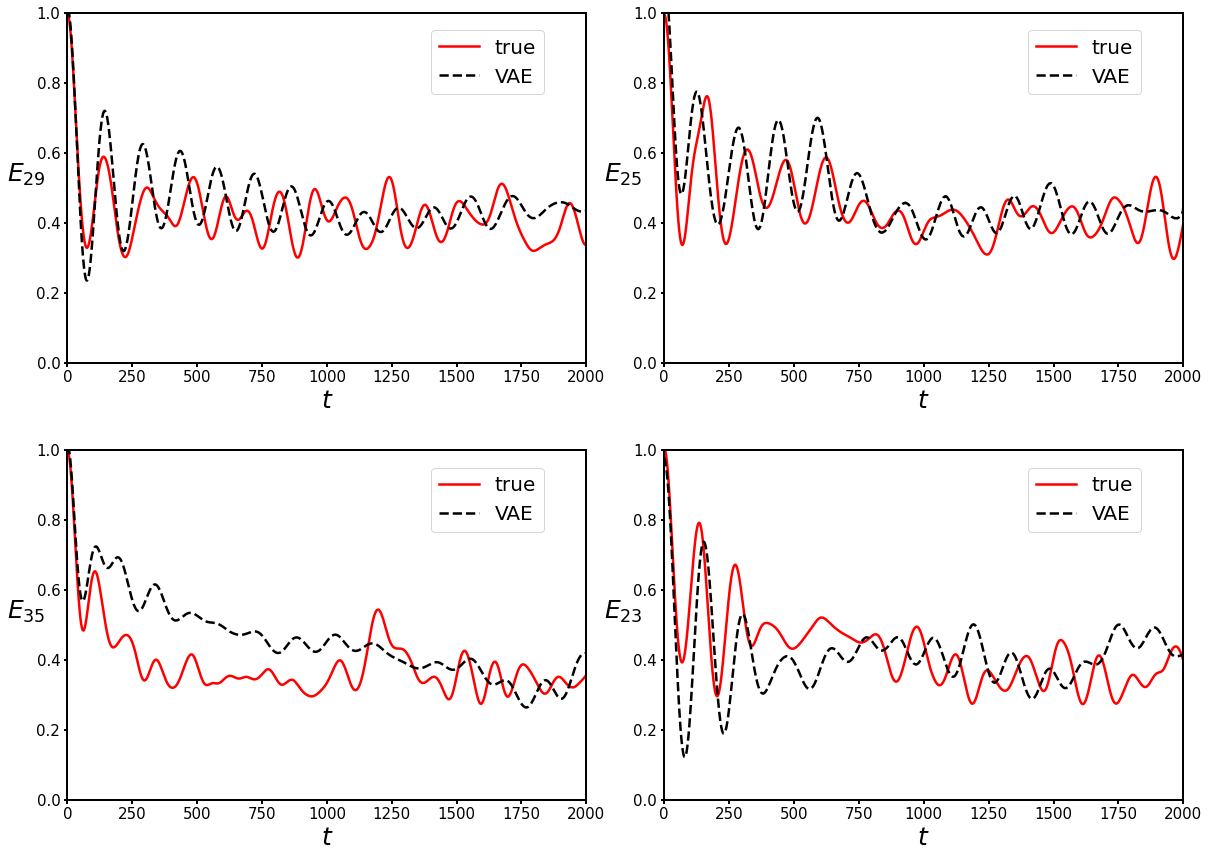

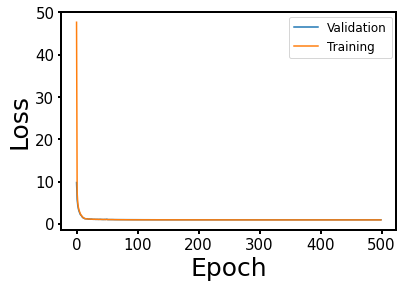

In [ ]:
epochs = 500

input_dim = testdata[0].shape[0]
z_dim = 20

opt_params = {'enc_dim': 256, 
              'rnn_layers': 0, 
              'beta': 0.0005, 
              'lr': 0.001}

encoder = Encoder(input_dim=input_dim,hidden_dim=opt_params['enc_dim'],
                  z_dim=z_dim)

decoder = Decoder(z_dim=z_dim, hidden_dim=opt_params['enc_dim'], 
                  output_dim=input_dim)

# vae
model = VAE(encoder, decoder)
model = model.to(device)

optimizer = optim.Adam(model.parameters(),lr=opt_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

loss_val = []
loss_train = []

for epoch in range(0, epochs):
    
    train_loss = loop(model, train_loader, epoch,loss_function, optimizer, beta = opt_params['beta'])
    val_loss = loop(model, val_loader, epoch, loss_function, optimizer, beta = opt_params['beta'], evaluation=True)
    scheduler.step(val_loss)
    
    loss_val.append(val_loss)
    loss_train.append(train_loss)
    # save model 
    
    if epoch % 10 == 0:
         torch.save(model.state_dict(),
                 '{}/Final_proj/vae-vanil.pth'.format(mydrive))
        
         torch.save(optimizer.state_dict(),
             '{}/Final_proj/optim-vanil.pth'.format(mydrive))
         
         np.savetxt(mydrive+'/Final_proj/val_loss_vanil.txt',loss_val)
         np.savetxt(mydrive+'/Final_proj/train_loss_vanil.txt',loss_train)
    
    if epoch == epochs-1:

        test_pred, test_true, test_loss = test_loop_vae(model, test_loader, loss_function, beta = opt_params['beta'])
        train_pred, __, train_loss = test_loop_vae(model, train_loader, loss_function, beta = opt_params['beta'])
        print('Test error is: {}\n'.format(test_loss))
        print('Train error is: {}\n'.format(train_loss))

        # Plotting
        test_true = test_loader.dataset
        filename = mydrive+'/Final_proj/vae'
        plotAE(test_pred, test_true, loss_val, loss_train, filename)

    
    if epoch == 0:
        best_loss = train_loss.item()
    else:
        if train_loss.item() < best_loss:
            best_loss = train_loss.item()



#Time-lagged autoencoder (in the time domain)

ODE block to encode the temporal properties of continuous dynamics 

In [ ]:
''' From the "Reduced-order Model for Fluid Flows via Neural Ordinary Differential Equations" by Rojas, et.al.
'''
class LatentOdeF(nn.Module):
    """ ODE-NN: takes the value z at the current time step and outputs the
        gradient dz/dt """

    def __init__(self, layers):
        super(LatentOdeF, self).__init__()

        self.act = nn.Tanh()
        self.layers = layers

        # Feedforward architecture
        arch = []
        for ind_layer in range(len(self.layers) - 2):
            layer = nn.Linear(self.layers[ind_layer], self.layers[ind_layer + 1])
            #Glorot initialization of tensor 
            nn.init.xavier_uniform_(layer.weight)
            arch.append(layer)

        layer = nn.Linear(self.layers[-2], self.layers[-1])
        nn.init.xavier_uniform_(layer.weight)
        layer.weight.data.fill_(0)
        arch.append(layer)

        self.linear_layers = nn.ModuleList(arch)
        self.nfe = 0

    def forward(self, t, z):

        self.nfe += 1

        #All, but last, layers have Tanh activation function
        for ind in range(len(self.layers) - 2):
            z = self.act(self.linear_layers[ind](z))

        # last layer has identity activation (i.e linear)
        grad = self.linear_layers[-1](z)
        return grad

#Re-defining VAE because it's slightly different
class VAE_NODE(nn.Module):
        ''' This the VAE function for the NODE method, which takes a encoder, decoder.
            Args:
            enc : Encoder function
            dec : Decoder function
            ode : ODE block function
        '''
        def __init__(self, enc, dec, node):
            super().__init__()

            self.enc = enc
            self.dec = dec
            self.node = node

        def forward(self, x):
            # encode
            z_mu, z_var = self.enc(x)

            # sample from the distribution having latent parameters z_mu, z_var
            # reparameterize
            z_std = torch.exp(z_var / 2)
            eps = torch.randn_like(z_std).to(device)
            z0 = eps.mul(z_std).add_(z_mu)
            #node latent space evolution
            ts_ode = np.linspace(0, 1, x.shape[0])
            ts_ode = torch.from_numpy(ts_ode).float().to(device) 
            #Solve system of diff equations using the ODE block, z0 initial values, and time points td_ode
            zt = odeint(self.node, z0, ts_ode, method='rk4').permute(1, 0, 2)
            # decode
            predicted = self.dec(zt)
            return predicted, z_mu, z_var

Defining lagged datasets and re-preparing data (because VAE used power spectrum)

In [ ]:
''' From "Time-lagged autoencoders: Deep learning of slow collectivevariables for molecular kinetics" by Wehmeyer et.al.
'''
class LaggedDataset(Dataset): 
    '''Dataset for wrapping time-lagged data from a single stored time series.
    Each sample will contain the data_tensor at index t and the (not explicitly
    stored) target_tensor via data_tensor at index t+lag. We need this for
    training the time-lagged autoencoder and TICA.
    Arguments:
        data_tensor (Tensor): contains time series data
        lag (int): specifies the lag in time steps
    '''
    def __init__(self, data_tensor, lag=1):
        assert data_tensor.size(0) > lag, 'you need more samples than lag'
        assert lag >= 0, 'you need a non-negative lagtime'
        self.data_tensor = data_tensor
        self.lag = lag
    def __getitem__(self, index):
        return self.data_tensor[index], self.data_tensor[index + self.lag]
    def __len__(self):
        return self.data_tensor.size(0) - self.lag

def define_loaders(lag, batch=4):
    ''' Take the time lag as input
    '''
    ens_TLA = choose_ens(rho300_00,k,1000)
    ens_TLA = ens_TLA.transpose()

    t_samples = ens_TLA.shape[0]

    X = torch.from_numpy(ens_TLA)
    tr, v, te = 0.7, 0.20, 0.10
    trwindow = int(tr*t_samples)
    vwindow = int(v*t_samples) + trwindow
    tewindow = t_samples - int(te*t_samples)

    X_train = X[:trwindow]
    X_val = X[:vwindow+1]
    X_test = X[tewindow:]

    traindata = LaggedDataset(X_train, lag=4)
    valdata = LaggedDataset(X_val,lag=4)
    testdata = LaggedDataset(X_test,lag=4)

    # Build dataloader 
    batchsize = 4
    train_loader = DataLoader(dataset=traindata,batch_size=batchsize,shuffle=False)
    val_loader = DataLoader(dataset=valdata,batch_size=batchsize,shuffle=False)
    test_loader = DataLoader(dataset=testdata,batch_size=batchsize,shuffle=False)

    return train_loader, val_loader, test_loader

Training the model

In [ ]:
def loop_TLA(model, loader, epoch, loss_fn, optimizer, beta=0.0001, evaluation=False):
    '''
        Train/test VAE model
    '''
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'

    batch_losses = []
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        x, y = data
        x = x.to(device)
        y = y.to(device)

        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_fn(recon_batch, y, mu, std, mse=False)
        loss = loss_recon + beta * loss_kl
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['recon loss={:.3f}'.format(loss_recon.item()) ,
                   'KL loss={:.3f}'.format(loss_kl.item()) ,
                   'total loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

def test_loop(model, loader, loss_fn, beta=0.0001):
    '''
       Testing model
    '''
    model.eval()
    mode = "eval"
    batch_losses = []
    samples = loader.dataset.__getitem__(0)[0].shape[0]
    all_preds = torch.empty(0,samples,dtype=float)
        
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    for data in tqdm_data:
        x, y = data
        x = x.to(device)
        y = y.to(device)

        recon_batch, mu, std = model(x)
        loss_recon, loss_kl = loss_fn(recon_batch, y, mu, std, mse=False)
        loss = loss_recon + beta * loss_kl

        batch_losses.append(loss.item())
        all_preds = torch.cat((all_preds.to(device),recon_batch.squeeze(0)),0)
    
    return all_preds, np.array(batch_losses).mean()

Function to plot the results

In [ ]:
def plotTLA(pred_data, true_data, lossTrain, lossVal, filename):
    '''
    Args:
      pred_data: the model prediction (from validation)
      true_data: the label to compare to
      lossTrainm loss_val: the arrays with train,val losses
      itr: epoch 
      train_winf: train window
    '''

    ###Plot to compare time-series
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(18, 15)

    plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.20, wspace=0.15)

    # vector to define time axis in plots
    t_steps_t = np.arange(0, true_data.shape[0])
    t_steps_p = np.arange(0, pred_data.shape[0])

    true_data = true_data.detach().cpu().numpy()
    pred_data = pred_data.detach().cpu().numpy()

    for k in range(4):

        ax = fig.add_subplot(3, 2, k + 1)
        ax.plot(t_steps_t, true_data[:, k], color='r', linewidth=2., alpha=1, label='true')
        ax.plot(t_steps_p, pred_data[:, k], 'k--', linewidth=2., label='NODE')

        ax.set_ylabel('$E_{%d}$' % (k + 1), rotation=0, size=20, labelpad=10)
        
        ax.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=20)

        ax.set_xlabel(r'$t$', size=20)

        plt.setp(ax.spines.values(), linewidth=2)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.xaxis.set_tick_params(width=2)
        ax.yaxis.set_tick_params(width=2)
        ax.set_xlim(0,len(t_steps_t))
        ax.set_ylim(-0.01,1)
        

    plt.savefig("%s.eps" % (filename+'_TLA_comp'),bbox_inches='tight')
    ##plot the train/val error
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Epoch",size=20)
    ax.set_ylabel("Loss",size=20)
    ax.plot(loss_val,label='Validation')
    ax.plot(loss_train,label='Training')
    plt.setp(ax.spines.values(), linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)

    ax.legend(bbox_to_anchor=(0.68, 0.98), loc='upper left', borderaxespad=0., fontsize=12)

    plt.savefig("%s.eps" % (filename+'_TLA_loss'),bbox_inches='tight')

#Results for TLE

Hyperparameter optimization

In [ ]:
train_loader, val_loader, tester_load = define_loaders(0, batch=4)

input_dim = train_loader.dataset.__getitem__(0)[0].shape[0]

hyper_dict = {
    "enc_dim": [64, 128, 256],
    "rnn_layers":[1, 2],
    "beta":[0.0001,0.0005],
    "lr":[5e-5,0.0001,0.001]
}
z_dim = 20

layers_node = [64] * 2 #Kept fixed because it's too costly to optimize too
node = LatentOdeF([z_dim] + layers_node + [z_dim])

print("Start trials") 

best_ehid, best_rnn, best_beta, best_lr, loss = hyperopt(loop_TLA, VAE_NODE, (train_loader,val_loader), 
                                                 Encoder, Decoder, hyper_dict, input_dim, z_dim, loss_function, n_epochs=4, ode=node)

opt_params = {
    "enc_dim": best_ehid,
    "rnn_layers": best_rnn,
    "beta": best_beta,
    "lr": best_lr
    }


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 62.71it/s, recon loss=0.502 KL loss=2.455 total loss=0.502 avg. loss=0.773]

Start trials
hidden dim = 64, rnn_layers = 1, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 66.64it/s, recon loss=0.410 KL loss=1.742 total loss=0.410 avg. loss=0.725]

hidden dim = 64, rnn_layers = 1, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 61.91it/s, recon loss=0.310 KL loss=17.399 total loss=0.312 avg. loss=0.684]

hidden dim = 64, rnn_layers = 1, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 63.01it/s, recon loss=0.451 KL loss=1.344 total loss=0.452 avg. loss=0.748]

hidden dim = 64, rnn_layers = 1, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.15it/s, recon loss=0.503 KL loss=2.273 total loss=0.504 avg. loss=0.777]

hidden dim = 64, rnn_layers = 1, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 60.78it/s, recon loss=0.426 KL loss=8.012 total loss=0.430 avg. loss=0.738]

hidden dim = 64, rnn_layers = 1, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 55.83it/s, recon loss=0.502 KL loss=0.277 total loss=0.502 avg. loss=0.774]

hidden dim = 64, rnn_layers = 2, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.84it/s, recon loss=0.504 KL loss=0.850 total loss=0.504 avg. loss=0.775]

hidden dim = 64, rnn_layers = 2, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 55.74it/s, recon loss=0.478 KL loss=5.538 total loss=0.479 avg. loss=0.772]

hidden dim = 64, rnn_layers = 2, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 55.81it/s, recon loss=0.505 KL loss=0.300 total loss=0.505 avg. loss=0.776]

hidden dim = 64, rnn_layers = 2, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 56.19it/s, recon loss=0.502 KL loss=0.311 total loss=0.502 avg. loss=0.774]

hidden dim = 64, rnn_layers = 2, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.51it/s, recon loss=0.429 KL loss=2.643 total loss=0.430 avg. loss=0.746]

hidden dim = 64, rnn_layers = 2, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 67.40it/s, recon loss=0.408 KL loss=1.356 total loss=0.408 avg. loss=0.721]

hidden dim = 128, rnn_layers = 1, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 55.26it/s, recon loss=0.501 KL loss=3.391 total loss=0.501 avg. loss=0.771]

hidden dim = 128, rnn_layers = 1, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.55it/s, recon loss=0.218 KL loss=45.592 total loss=0.223 avg. loss=0.630]

hidden dim = 128, rnn_layers = 1, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 49.90it/s, recon loss=0.616 KL loss=0.846 total loss=0.617 avg. loss=0.829]

hidden dim = 128, rnn_layers = 1, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 62.09it/s, recon loss=0.451 KL loss=1.151 total loss=0.451 avg. loss=0.748]

hidden dim = 128, rnn_layers = 1, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 56.41it/s, recon loss=0.301 KL loss=15.038 total loss=0.308 avg. loss=0.710]

hidden dim = 128, rnn_layers = 1, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 57.56it/s, recon loss=0.499 KL loss=0.321 total loss=0.499 avg. loss=0.771]

hidden dim = 128, rnn_layers = 2, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 57.47it/s, recon loss=0.502 KL loss=0.784 total loss=0.502 avg. loss=0.775]

hidden dim = 128, rnn_layers = 2, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 57.77it/s, recon loss=0.244 KL loss=19.949 total loss=0.246 avg. loss=0.684]

hidden dim = 128, rnn_layers = 2, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.06it/s, recon loss=0.502 KL loss=0.204 total loss=0.502 avg. loss=0.775]

hidden dim = 128, rnn_layers = 2, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 57.44it/s, recon loss=0.499 KL loss=0.241 total loss=0.499 avg. loss=0.773]

hidden dim = 128, rnn_layers = 2, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 51.97it/s, recon loss=0.300 KL loss=12.822 total loss=0.307 avg. loss=0.717]

hidden dim = 128, rnn_layers = 2, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 60.01it/s, recon loss=0.451 KL loss=1.881 total loss=0.451 avg. loss=0.748]

hidden dim = 256, rnn_layers = 1, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.51it/s, recon loss=0.496 KL loss=6.329 total loss=0.496 avg. loss=0.772]

hidden dim = 256, rnn_layers = 1, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 62.31it/s, recon loss=0.227 KL loss=49.692 total loss=0.232 avg. loss=0.552]

hidden dim = 256, rnn_layers = 1, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 54.55it/s, recon loss=0.557 KL loss=0.236 total loss=0.557 avg. loss=0.802]

hidden dim = 256, rnn_layers = 1, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:05, 59.46it/s, recon loss=0.442 KL loss=1.540 total loss=0.443 avg. loss=0.745]

hidden dim = 256, rnn_layers = 1, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 67.57it/s, recon loss=0.248 KL loss=36.706 total loss=0.266 avg. loss=0.589]

hidden dim = 256, rnn_layers = 1, beta = 0.0005 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 51.77it/s, recon loss=0.556 KL loss=0.446 total loss=0.556 avg. loss=0.801]

hidden dim = 256, rnn_layers = 2, beta = 0.0001 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:07, 48.42it/s, recon loss=0.610 KL loss=2.266 total loss=0.610 avg. loss=0.827]

hidden dim = 256, rnn_layers = 2, beta = 0.0001 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 52.75it/s, recon loss=0.186 KL loss=56.364 total loss=0.191 avg. loss=0.631]

hidden dim = 256, rnn_layers = 2, beta = 0.0001 and lr = 0.001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 53.61it/s, recon loss=0.554 KL loss=0.152 total loss=0.554 avg. loss=0.799]

hidden dim = 256, rnn_layers = 2, beta = 0.0005 and lr = 5e-05


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 53.61it/s, recon loss=0.551 KL loss=0.308 total loss=0.551 avg. loss=0.798]

hidden dim = 256, rnn_layers = 2, beta = 0.0005 and lr = 0.0001


train (epoch #0):   2%|▏         | 6/349 [00:00<00:06, 55.39it/s, recon loss=0.268 KL loss=22.779 total loss=0.279 avg. loss=0.627]

hidden dim = 256, rnn_layers = 2, beta = 0.0005 and lr = 0.001


eval (epoch #3): 100%|██████████| 450/450 [00:04<00:00, 95.62it/s, recon loss=0.065 KL loss=0.247 total loss=0.065 avg. loss=0.088]


 -----------------------------------------------------------------------
best parameter set: {'enc_dim': 256, 'rnn_layers': 0, 'beta': 0.0005, 'lr': 5e-05}
best loss 0.07705041378736496


Correction on the opt_params print (RNN parameter print above is incorrect)

In [ ]:
opt_params = {
    "enc_dim": best_ehid,
    "rnn_layers": best_rnn,
    "beta": best_beta,
    "lr": best_lr
    }
    
print("best parameter set: {}".format(opt_params))
print("best loss {}".format(loss))

best parameter set: {'enc_dim': 256, 'rnn_layers': 1, 'beta': 0.0005, 'lr': 5e-05}
best loss 0.07705041378736496


In [ ]:
input_dim =  train_loader.dataset.__getitem__(0)[0].shape[0] # or 1000
z_dim = 20


encoder = Encoder(input_dim=input_dim,hidden_dim=opt_params['enc_dim'],
                  z_dim=z_dim,rnn_layers=opt_params['rnn_layers'])

decoder = Decoder(z_dim=z_dim, hidden_dim=opt_params['enc_dim'], 
                  output_dim=input_dim,rnn_layers=opt_params['rnn_layers'])

#This should have bene optimized too
layers_node = [64] * 2 
node = LatentOdeF([z_dim] + layers_node + [z_dim])

Running for 200 epochs.
Results are calculated for different time lags for comparison.

train (epoch #0):   2%|▏         | 7/349 [00:00<00:05, 60.99it/s, recon loss=0.058 KL loss=2.964 total loss=0.060 avg. loss=0.068]


Starting time lag 0

---------------------------------------------------------------------------------



train (epoch #10):   2%|▏         | 7/349 [00:00<00:05, 66.57it/s, recon loss=0.063 KL loss=4.416 total loss=0.066 avg. loss=0.070]

Epoch    10: reducing learning rate of group 0 to 2.5000e-05.


train (epoch #16):   2%|▏         | 7/349 [00:00<00:05, 61.49it/s, recon loss=0.059 KL loss=4.578 total loss=0.062 avg. loss=0.054]

Epoch    16: reducing learning rate of group 0 to 1.2500e-05.


train (epoch #22):   2%|▏         | 6/349 [00:00<00:05, 58.43it/s, recon loss=0.067 KL loss=5.897 total loss=0.069 avg. loss=0.061]

Epoch    22: reducing learning rate of group 0 to 6.2500e-06.


train (epoch #56):   2%|▏         | 6/349 [00:00<00:06, 54.32it/s, recon loss=0.042 KL loss=5.026 total loss=0.044 avg. loss=0.049]

Epoch    56: reducing learning rate of group 0 to 3.1250e-06.


train (epoch #77):   2%|▏         | 7/349 [00:00<00:05, 61.92it/s, recon loss=0.044 KL loss=5.308 total loss=0.046 avg. loss=0.043]

Epoch    77: reducing learning rate of group 0 to 1.5625e-06.


train (epoch #91):   0%|          | 0/349 [00:00<?, ?it/s, recon loss=0.029 KL loss=12.539 total loss=0.036 avg. loss=0.043]

Epoch    91: reducing learning rate of group 0 to 7.8125e-07.


train (epoch #102):   2%|▏         | 7/349 [00:00<00:05, 61.93it/s, recon loss=0.034 KL loss=5.188 total loss=0.037 avg. loss=0.040]

Epoch   102: reducing learning rate of group 0 to 3.9063e-07.


train (epoch #108):   2%|▏         | 6/349 [00:00<00:06, 56.59it/s, recon loss=0.031 KL loss=5.165 total loss=0.034 avg. loss=0.040]

Epoch   108: reducing learning rate of group 0 to 1.9531e-07.


train (epoch #115):   2%|▏         | 7/349 [00:00<00:05, 58.87it/s, recon loss=0.036 KL loss=5.127 total loss=0.039 avg. loss=0.041]

Epoch   115: reducing learning rate of group 0 to 9.7656e-08.


eval (epoch #120): 100%|██████████| 450/450 [00:04<00:00, 101.02it/s, recon loss=0.520 KL loss=23.085 total loss=0.532 avg. loss=0.049]


Epoch   121: reducing learning rate of group 0 to 4.8828e-08.


train (epoch #127):   2%|▏         | 6/349 [00:00<00:05, 59.57it/s, recon loss=0.031 KL loss=5.144 total loss=0.034 avg. loss=0.040]

Epoch   127: reducing learning rate of group 0 to 2.4414e-08.


train (epoch #133):   2%|▏         | 7/349 [00:00<00:05, 62.54it/s, recon loss=0.038 KL loss=4.687 total loss=0.040 avg. loss=0.041]

Epoch   133: reducing learning rate of group 0 to 1.2207e-08.


eval (epoch #199): 100%|██████████| 349/349 [00:02<00:00, 169.53it/s]


Test error is: 0.05994086575751402, with lag 0

Train error is: 0.04472339838572423, with lag 0



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back


Starting time lag 3

---------------------------------------------------------------------------------



train (epoch #9):   2%|▏         | 6/349 [00:00<00:05, 59.46it/s, recon loss=0.047 KL loss=4.095 total loss=0.049 avg. loss=0.056]

Epoch     9: reducing learning rate of group 0 to 2.5000e-05.


train (epoch #15):   2%|▏         | 7/349 [00:00<00:05, 64.79it/s, recon loss=0.054 KL loss=4.031 total loss=0.056 avg. loss=0.060]

Epoch    15: reducing learning rate of group 0 to 1.2500e-05.


train (epoch #21):   0%|          | 0/349 [00:00<?, ?it/s, recon loss=0.037 KL loss=13.368 total loss=0.044 avg. loss=0.057]

Epoch    21: reducing learning rate of group 0 to 6.2500e-06.


train (epoch #27):   1%|▏         | 5/349 [00:00<00:06, 49.70it/s, recon loss=0.051 KL loss=5.362 total loss=0.053 avg. loss=0.051]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.


train (epoch #94):   2%|▏         | 6/349 [00:00<00:06, 54.86it/s, recon loss=0.037 KL loss=5.824 total loss=0.040 avg. loss=0.043]

Epoch    94: reducing learning rate of group 0 to 1.5625e-06.


train (epoch #109):   2%|▏         | 6/349 [00:00<00:06, 51.94it/s, recon loss=0.045 KL loss=7.020 total loss=0.049 avg. loss=0.042]

Epoch   109: reducing learning rate of group 0 to 7.8125e-07.


train (epoch #122):   2%|▏         | 6/349 [00:00<00:06, 52.66it/s, recon loss=0.039 KL loss=7.050 total loss=0.042 avg. loss=0.041]

Epoch   122: reducing learning rate of group 0 to 3.9063e-07.


train (epoch #130):   2%|▏         | 6/349 [00:00<00:06, 55.29it/s, recon loss=0.037 KL loss=5.550 total loss=0.040 avg. loss=0.041]

Epoch   130: reducing learning rate of group 0 to 1.9531e-07.


train (epoch #136):   2%|▏         | 7/349 [00:00<00:05, 63.10it/s, recon loss=0.037 KL loss=4.560 total loss=0.039 avg. loss=0.040]

Epoch   136: reducing learning rate of group 0 to 9.7656e-08.


train (epoch #142):   2%|▏         | 6/349 [00:00<00:06, 54.49it/s, recon loss=0.032 KL loss=4.591 total loss=0.035 avg. loss=0.038]

Epoch   142: reducing learning rate of group 0 to 4.8828e-08.


train (epoch #154):   2%|▏         | 6/349 [00:00<00:06, 56.32it/s, recon loss=0.030 KL loss=4.583 total loss=0.033 avg. loss=0.039]

Epoch   154: reducing learning rate of group 0 to 2.4414e-08.


train (epoch #162):   2%|▏         | 6/349 [00:00<00:05, 58.16it/s, recon loss=0.034 KL loss=4.591 total loss=0.036 avg. loss=0.039]

Epoch   162: reducing learning rate of group 0 to 1.2207e-08.


eval (epoch #199): 100%|██████████| 349/349 [00:02<00:00, 172.02it/s]


Test error is: 0.0612033555398182, with lag 3

Train error is: 0.04480416945216478, with lag 3



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back


Starting time lag 5

---------------------------------------------------------------------------------



train (epoch #9):   2%|▏         | 6/349 [00:00<00:06, 56.90it/s, recon loss=0.070 KL loss=3.715 total loss=0.072 avg. loss=0.089]

Epoch     9: reducing learning rate of group 0 to 2.5000e-05.


train (epoch #15):   2%|▏         | 6/349 [00:00<00:06, 52.52it/s, recon loss=0.055 KL loss=5.150 total loss=0.058 avg. loss=0.061]

Epoch    15: reducing learning rate of group 0 to 1.2500e-05.


train (epoch #21):   0%|          | 0/349 [00:00<?, ?it/s, recon loss=0.042 KL loss=15.280 total loss=0.050 avg. loss=0.054]

Epoch    21: reducing learning rate of group 0 to 6.2500e-06.


train (epoch #27):   2%|▏         | 7/349 [00:00<00:05, 59.44it/s, recon loss=0.051 KL loss=5.138 total loss=0.053 avg. loss=0.046]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.


train (epoch #103):   2%|▏         | 6/349 [00:00<00:06, 54.40it/s, recon loss=0.040 KL loss=6.848 total loss=0.044 avg. loss=0.041]

Epoch   103: reducing learning rate of group 0 to 1.5625e-06.


train (epoch #121):   0%|          | 0/349 [00:00<?, ?it/s, recon loss=0.029 KL loss=16.459 total loss=0.037 avg. loss=0.043]

Epoch   121: reducing learning rate of group 0 to 7.8125e-07.


train (epoch #133):   1%|▏         | 5/349 [00:00<00:07, 48.97it/s, recon loss=0.032 KL loss=6.630 total loss=0.035 avg. loss=0.038]

Epoch   133: reducing learning rate of group 0 to 3.9063e-07.


train (epoch #145):   2%|▏         | 6/349 [00:00<00:05, 58.09it/s, recon loss=0.040 KL loss=5.453 total loss=0.043 avg. loss=0.040]

Epoch   145: reducing learning rate of group 0 to 1.9531e-07.


train (epoch #152):   2%|▏         | 6/349 [00:00<00:06, 54.27it/s, recon loss=0.035 KL loss=5.459 total loss=0.038 avg. loss=0.038]

Epoch   152: reducing learning rate of group 0 to 9.7656e-08.


train (epoch #159):   2%|▏         | 6/349 [00:00<00:05, 59.61it/s, recon loss=0.033 KL loss=4.755 total loss=0.036 avg. loss=0.039]

Epoch   159: reducing learning rate of group 0 to 4.8828e-08.


train (epoch #165):   2%|▏         | 6/349 [00:00<00:06, 54.25it/s, recon loss=0.034 KL loss=4.755 total loss=0.036 avg. loss=0.038]

Epoch   165: reducing learning rate of group 0 to 2.4414e-08.


train (epoch #172):   2%|▏         | 6/349 [00:00<00:06, 56.21it/s, recon loss=0.032 KL loss=4.763 total loss=0.035 avg. loss=0.037]

Epoch   172: reducing learning rate of group 0 to 1.2207e-08.


eval (epoch #199): 100%|██████████| 349/349 [00:02<00:00, 163.10it/s]


Test error is: 0.06245546217779724, with lag 5

Train error is: 0.04444705357609642, with lag 5



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

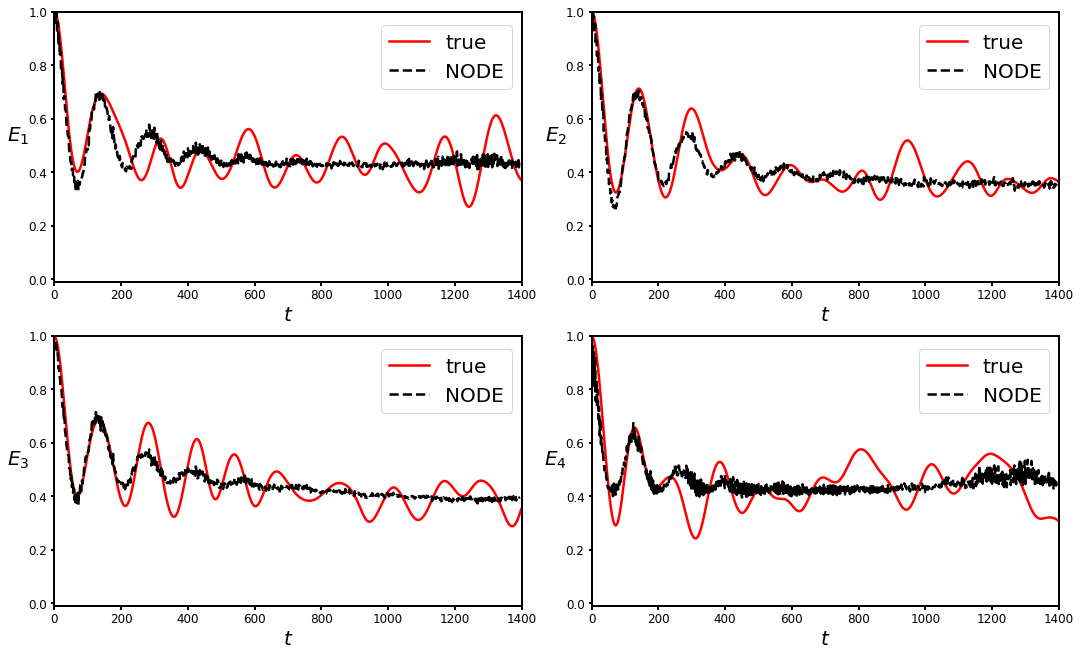

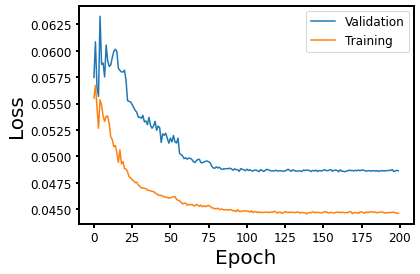

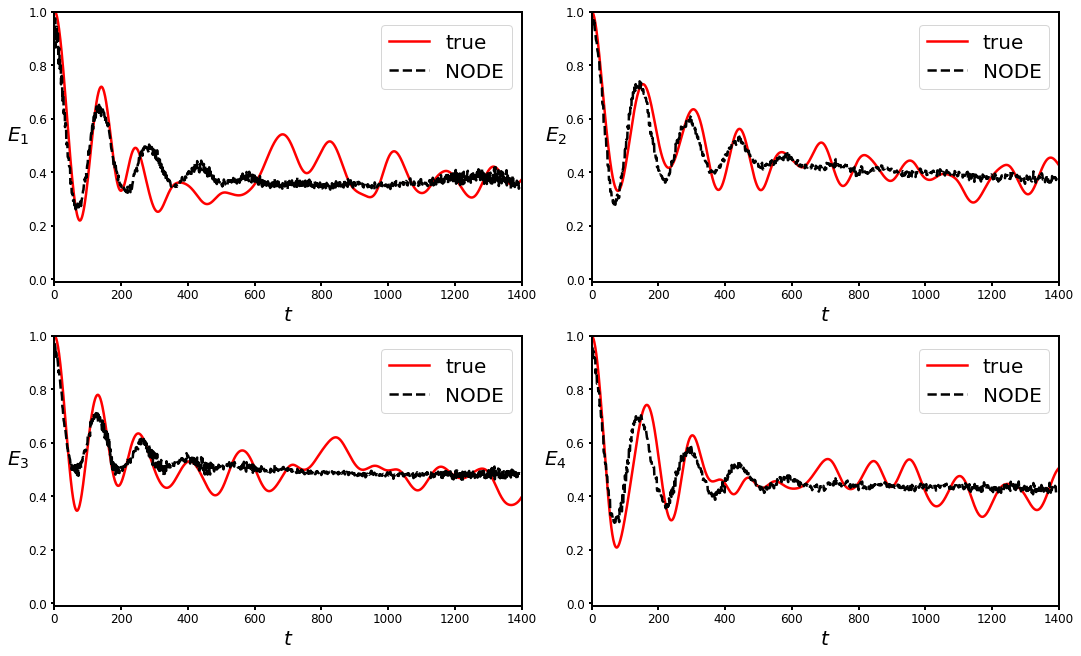

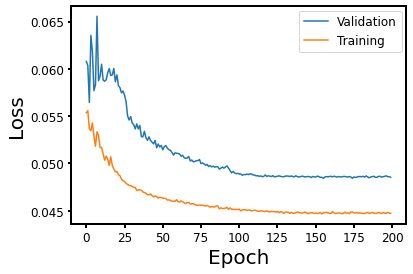

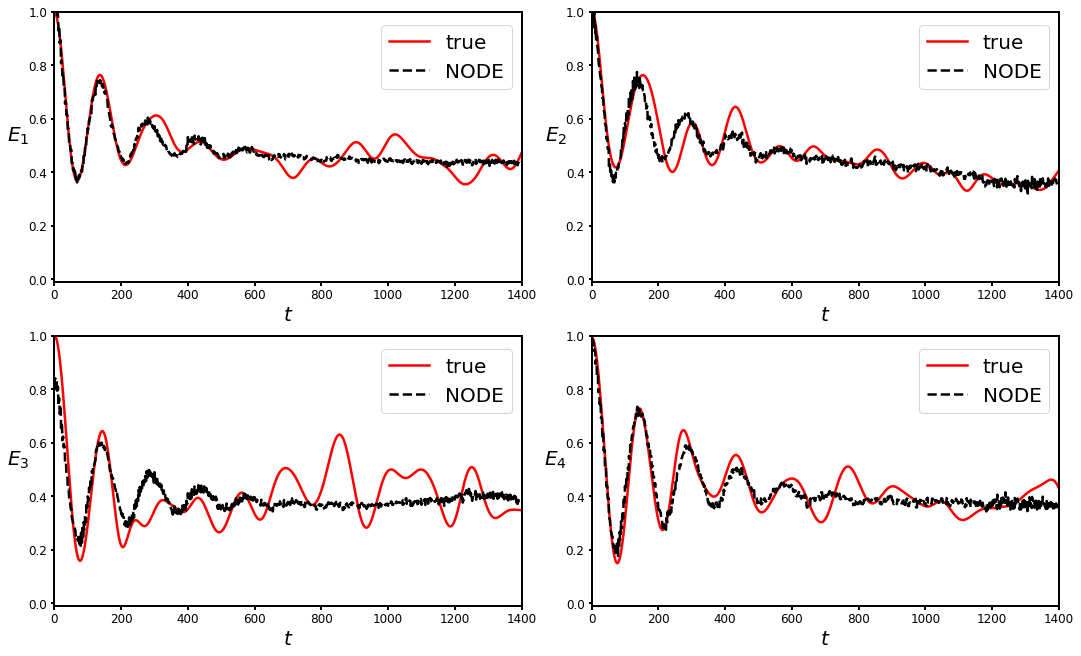

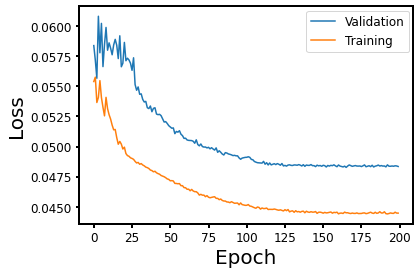

In [ ]:
epochs = 200

for lag in [0,3,5]:

    # vae
    ##The model is restarted so the results for different lags are comparable
    model = VAE_NODE(encoder, decoder, node)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(),lr=opt_params['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

    loss_val = []
    loss_train = []

    train_load, val_load, test_load = define_loaders(lag, batch=4)

    print('\nStarting time lag '+str(lag)+'\n')
    print('---------------------------------------------------------------------------------\n')

    for epoch in range(0, epochs):
        
        train_loss = loop_TLA(model, train_load, epoch,loss_function, optimizer, beta = opt_params['beta'])
        val_loss = loop_TLA(model, val_load, epoch, loss_function, optimizer, beta = opt_params['beta'], evaluation=True)
        scheduler.step(val_loss)
        
        loss_val.append(val_loss)
        loss_train.append(train_loss)
        # save model 
        
        if epoch % 10 == 0:
            torch.save(model.state_dict(),
                    '{}/Final_proj/vae-TLA{}.pth'.format(mydrive, str(lag)))
            
            torch.save(optimizer.state_dict(),
                '{}/Final_proj/optim-TLA{}.pth'.format(mydrive, str(lag)))
            
            np.savetxt(mydrive+'/Final_proj/val_loss_TLA-'+str(lag)+'.txt',loss_val)
            np.savetxt(mydrive+'/Final_proj/train_loss_TLA-'+str(lag)+'.txt',loss_train)
        
        if epoch == epochs-1:

            test_pred, test_loss = test_loop(model, test_load, loss_function, beta = opt_params['beta'])
            train_pred, train_loss = test_loop(model, train_load, loss_function, beta = opt_params['beta'])
            print('Test error is: {}, with lag {}\n'.format(test_loss,lag))
            print('Train error is: {}, with lag {}\n'.format(train_loss,lag))

            output_vae = (train_pred) 
            filename = mydrive+'/Final_proj/lag'+str(lag)
            plotTLA(output_vae, train_load.dataset.data_tensor, train_loss, val_loss, filename)

        
        if epoch == 0:
            best_loss = train_loss.item()
        else:
            if train_loss.item() < best_loss:
                best_loss = train_loss.item()

Re-print of the lag=5 results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

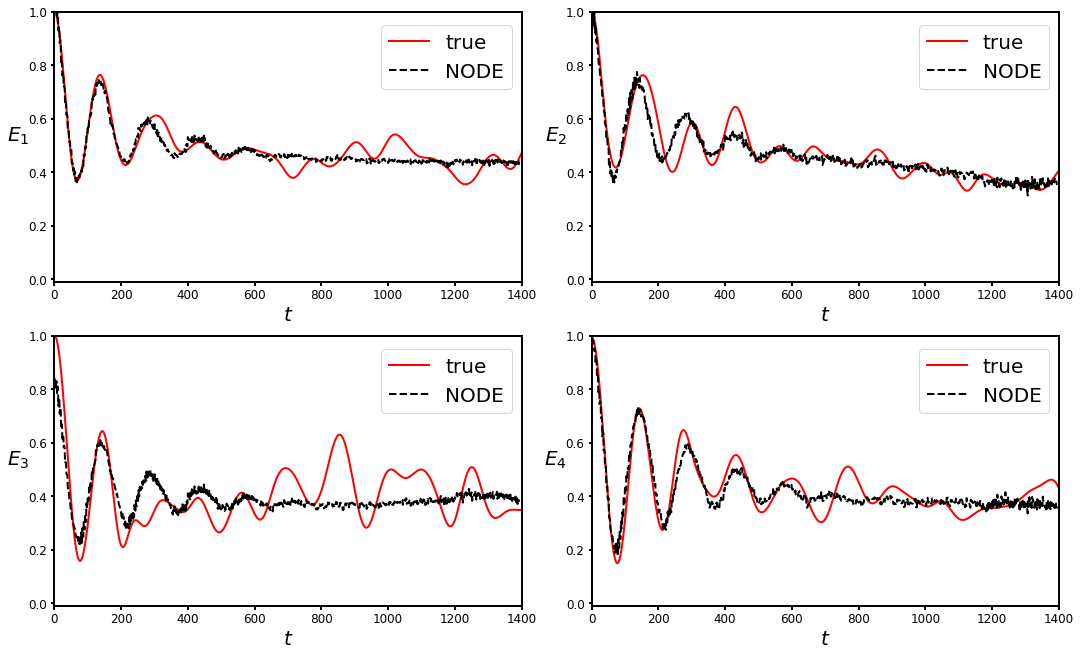

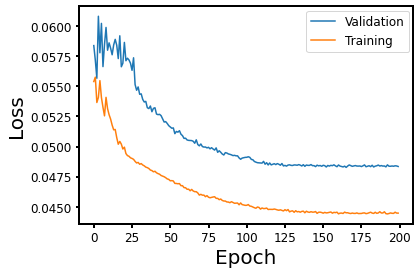

In [ ]:
output_vae = (train_pred) 
filename = mydrive+'/Final_proj/lag'+str(lag)
plotTLA(output_vae, train_load.dataset.data_tensor, train_loss, val_loss, filename)

#Analysing the VAE latent space

Loading VAE model state dictionary

In [ ]:
input_dim = testdata[0].shape[0]

zdim = 20
opt_params = {'enc_dim': 256, 
              'rnn_layers': 0, 
              'beta': 0.0005, 
              'lr': 0.001}

encoder = Encoder(input_dim=input_dim,hidden_dim=opt_params['enc_dim'],
                  z_dim=zdim)

decoder = Decoder(z_dim=zdim, hidden_dim=opt_params['enc_dim'], 
                  output_dim=input_dim)


model = VAE(encoder, decoder)
model = model.to(device)

optimizer = optim.Adam(model.parameters(),lr=opt_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

model.load_state_dict(torch.load('{}/Final_proj/vae-vanil.pth'.format(mydrive)))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
enc.linear.weight 	 torch.Size([256, 4002])
enc.linear.bias 	 torch.Size([256])
enc.mu.weight 	 torch.Size([20, 256])
enc.mu.bias 	 torch.Size([20])
enc.var.weight 	 torch.Size([20, 256])
enc.var.bias 	 torch.Size([20])
dec.linear.weight 	 torch.Size([256, 20])
dec.linear.bias 	 torch.Size([256])
dec.out.weight 	 torch.Size([4002, 256])
dec.out.bias 	 torch.Size([4002])


In [ ]:
enc_mu = model.state_dict()['enc.mu.weight'] + model.state_dict()['enc.mu.bias'].unsqueeze(1)
enc_var = model.state_dict()['enc.var.weight'] + model.state_dict()['enc.var.bias'].unsqueeze(1)

In [ ]:
def decode_redz(x, model, red_dim,):
    ''' Decodes a reduced representation of the latent space
    '''
    red_i, red_f = red_dim
    x = x.to(device)

    for param_tensor in model.state_dict():
        param = param_tensor.split(".")
        param_name = param[0]+"_"+param[1]+"_"+param[2]
        value = model.state_dict()[param_tensor]
        #exec("%s = %d" % (param_name,value))
        globals()[param_name] = value

    def linear(weight, bias, xi):
        xi = xi.float()
        wgt = weight.T
        b = bias.unsqueeze(0)
        return torch.mm(xi,wgt).add_(b)

    #encode
    x_enc = F.relu(linear(enc_linear_weight,enc_linear_bias,x))
    red_mu = linear(enc_mu_weight[red_i:red_f],enc_mu_bias[red_i:red_f],x_enc)
    red_var = linear(enc_var_weight[red_i:red_f],enc_var_bias[red_i:red_f],x_enc)
    
    red_var = red_var.to(device)
    red_mu = red_mu.to(device)
    #reparametrize
    red_std = torch.exp(red_var / 2)
    eps = torch.randn_like(red_std).to(device)
    red_z =  eps.mul(red_std).add_(red_mu)

    # decode
    x_dec = F.relu(linear(dec_linear_weight[:,red_i:red_f],dec_linear_bias,red_z))
    x_out = linear(dec_out_weight,dec_out_bias,x_dec)

    return x_out


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript bac

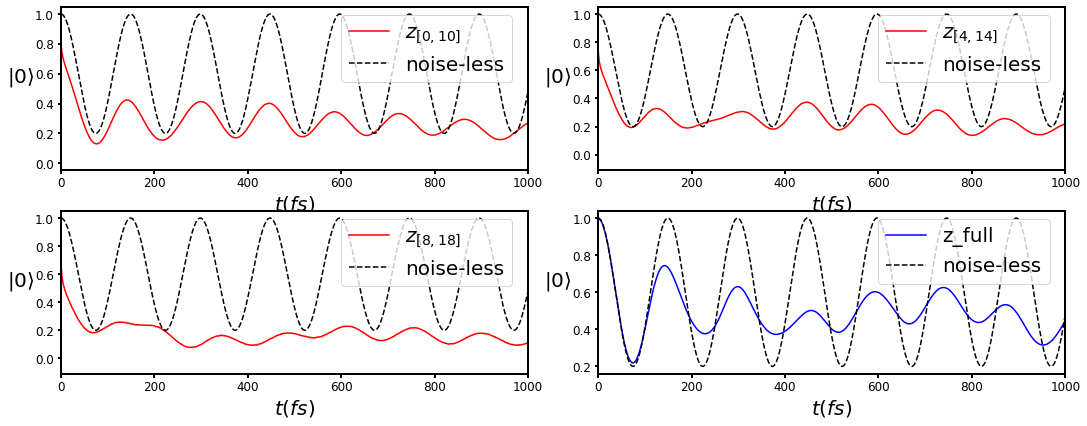

In [ ]:
x_test = X_test[0].unsqueeze(0)
win = 10
st = 4
for idx,mv in enumerate(range(0,20-win,st)):
    ps_pred = decode_redz(x_test,model,(mv,mv+win))
    #Back to time domain
    ps_pred = ps_pred.detach().cpu().numpy()
    ts_recon = power_recon(ps_pred).squeeze()

    #Figure
    fig = plt.gcf()
    fig.set_size_inches(18, 6)
    plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.25, wspace=0.15)
    ax = fig.add_subplot(2, 2, idx + 1)

    ax.plot(ts_recon, color='r', linewidth=1.5, alpha=1, label='$z_{[%d,%d]}$' % (mv,mv+win))
    ax.plot(closed_pop, 'k--', linewidth=1.5, label='noise-less')

    ax.set_ylabel(r'$|0\rangle$', rotation=0, size=20, labelpad=14)
    ax.legend(bbox_to_anchor=(0.6, 0.95), loc='upper left', borderaxespad=0., fontsize=20)
    ax.set_xlabel(r'$t(fs)$', size=20)

    plt.setp(ax.spines.values(), linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.set_xlim(0,1000)
    #ax.set_ylim(0,1)

ps_full = x_test
ps_full = ps_full.detach().cpu().numpy()
ts_full = power_recon(ps_full).squeeze()
ax = fig.add_subplot(2, 2, idx + 2)

ax.plot(ts_full, color='b', linewidth=1.5, alpha=1, label='z_full')
ax.plot(closed_pop, 'k--', linewidth=1.5, label='noise-less')

ax.set_ylabel(r'$|0\rangle$', rotation=0, size=20, labelpad=14)
ax.legend(bbox_to_anchor=(0.6, 0.95), loc='upper left', borderaxespad=0., fontsize=20)
ax.set_xlabel(r'$t(fs)$', size=20)

plt.setp(ax.spines.values(), linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
ax.set_xlim(0,1000)

plt.savefig("%s.eps" % (mydrive+'/Final_proj/latent_parts'),bbox_inches='tight')


Visualizing the latent space in 2D (PCA and t-SNE dimensionality reduction)

- For the encoded mean

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

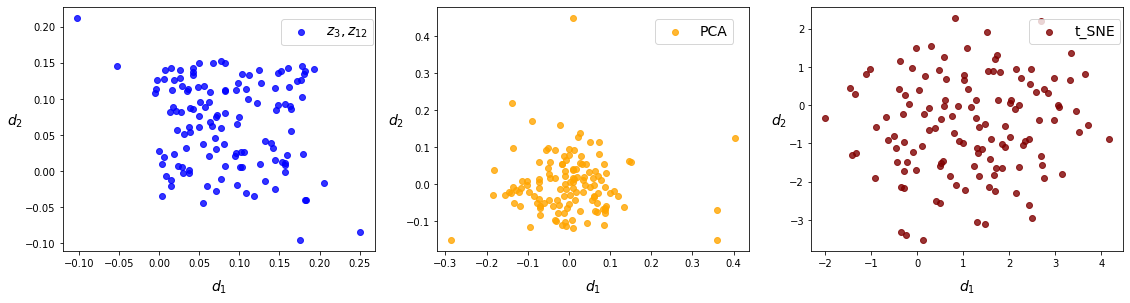

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

encod_mu = enc_mu.T.detach().cpu().numpy()
#t_SNE
z_embed = lambda p: TSNE(n_components=2,perplexity=p).fit_transform(encod_mu)
#PCA
pca = PCA(n_components=2)
mu_pca = pca.fit_transform(encod_mu)

fig = plt.gcf()
fig.set_size_inches(19, 4)
plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.25, wspace=0.2)
ax1 = fig.add_subplot(131)

rdm1 = np.random.randint(20)
rdm2 = np.random.randint(20)
ax1.scatter(encod_mu[:,rdm1],encod_mu[:,rdm2],alpha=0.8,label='$z_{%d},z_{%d}$' % (rdm1,rdm2),color='blue')

ax2 = fig.add_subplot(132)
ax2.scatter(mu_pca[:,0],mu_pca[:,1],alpha=0.8,label='PCA',color='orange')

ax3 = fig.add_subplot(133)
z_50 = z_embed(50)
ax3.scatter(z_50[:,0],z_50[:,1],alpha=0.8,label='t_SNE',color='maroon')

ax1.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=14)
ax2.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=14)
ax3.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=14)


ax1.set_xlabel(r'$d_1$', rotation=0, size=14, labelpad=10)
ax1.set_ylabel(r'$d_2$', rotation=0, size=14, labelpad=10)

ax2.set_xlabel(r'$d_1$', rotation=0, size=14, labelpad=10)
ax2.set_ylabel(r'$d_2$', rotation=0, size=14, labelpad=10)

ax3.set_xlabel(r'$d_1$', rotation=0, size=14, labelpad=10)
ax3.set_ylabel(r'$d_2$', rotation=0, size=14, labelpad=10)

plt.savefig("%s.eps" % (mydrive+'/Final_proj/latent_mu_vis'),bbox_inches='tight')


- For the encoded variance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

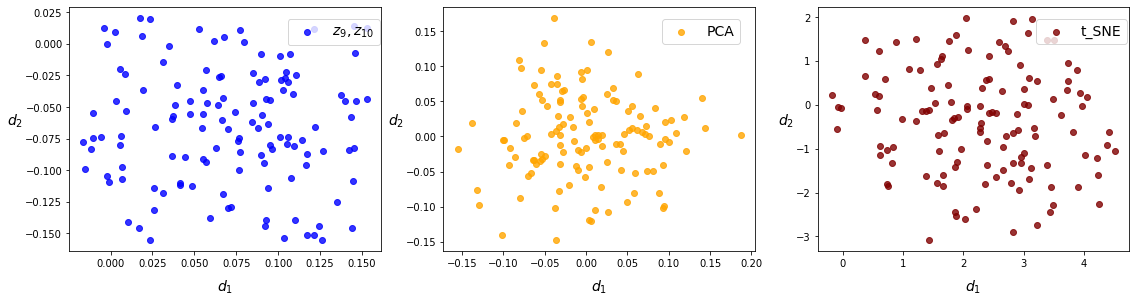

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

encod_var = enc_var.T.detach().cpu().numpy()
#t_SNE
z_embed = lambda p: TSNE(n_components=2,perplexity=p).fit_transform(encod_var)
#PCA
pca = PCA(n_components=2)
var_pca = pca.fit_transform(encod_var)

fig = plt.gcf()
fig.set_size_inches(19, 4)
plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.25, wspace=0.2)
ax1 = fig.add_subplot(131)

rdm1 = np.random.randint(20)
rdm2 = np.random.randint(20)
ax1.scatter(encod_var[:,rdm1],encod_var[:,rdm2],alpha=0.8,label='$z_{%d},z_{%d}$' % (rdm1,rdm2),color='blue')

ax2 = fig.add_subplot(132)
ax2.scatter(var_pca[:,0],var_pca[:,1],alpha=0.8,label='PCA',color='orange')

ax3 = fig.add_subplot(133)
z_50 = z_embed(50)
ax3.scatter(z_50[:,0],z_50[:,1],alpha=0.8,label='t_SNE',color='maroon')

ax1.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=14)
ax2.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=14)
ax3.legend(bbox_to_anchor=(0.7, 0.95), loc='upper left', borderaxespad=0., fontsize=14)


ax1.set_xlabel(r'$d_1$', rotation=0, size=14, labelpad=10)
ax1.set_ylabel(r'$d_2$', rotation=0, size=14, labelpad=10)

ax2.set_xlabel(r'$d_1$', rotation=0, size=14, labelpad=10)
ax2.set_ylabel(r'$d_2$', rotation=0, size=14, labelpad=10)

ax3.set_xlabel(r'$d_1$', rotation=0, size=14, labelpad=10)
ax3.set_ylabel(r'$d_2$', rotation=0, size=14, labelpad=10)

plt.savefig("%s.eps" % (mydrive+'/Final_proj/latent_var_vis'),bbox_inches='tight')
